In [1]:
import sys

# laptop
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )
af_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/'
fig_path = 'figures/multiyear_figs/'
# UNM desktop
#sys.path.append( '..\\NMEG_utils\\py_modules\\' )
#af_path = 'C:\\Research_Flux_Towers\\Ameriflux_files\\'
#fig_path = 'figures\\multiyear_figs\\'

import load_nmeg as ld
import transform_nmeg as tr
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
#import ipdb as ipdb

%matplotlib inline
sns.set_style("white")

In [2]:
# Years to load
start = 2007
end = 2014
# Sites to load
sites = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']

# Fill a dict with multiyear dataframes for each site in sites
hourly = { x : 
          ld.get_multiyr_aflx( 'US-' + x, af_path, gapfilled=True, startyear=start, endyear=end) 
          for x in sites }

Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2007_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2008_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2010_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2011_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2012_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2013_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2014_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2007_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2008_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_

## Hours per day of C uptake and evaporative fraction

In [37]:
for site in sites:
    hourly[site]['hrs_C_uptake'] = 0
    test = hourly[site].FC_F < 0
    hourly[site].loc[test, 'hrs_C_uptake'] = 0.5
    
    hourly[site]['evap_frac'] = np.nan
    bowen =  hourly[site].H_F / hourly[site].LE_F
    hourly[site].evap_frac = 1/(1+bowen)
    day_test = hourly[site].SW_IN_F < 50
    hourly[site].loc[day_test, 'evap_frac'] = np.nan
    

# Beware here that the bowen ration looks a little crazy, especially at night.
# Perhaps we need to do a better job of removing/correcting H and LE fluxes

In [38]:
# Resample all hourly dataframes in Hourly to daily and add to daily dict
daily = { x : 
         tr.resample_30min_aflx( hourly[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET', 'VPD_F', 'evap_frac' ], 
                                sum_cols=[ 'P_F', 'hrs_C_uptake' ] , tair_col='TA_F' ) 
         for x in hourly.keys() }

# Convert this to a pandas panel
d = pd.Panel(daily)

## Calculate first day of growing season

In [49]:
# Group positive/negative days into groups for each year using shift-compare-cumsum method
df = d.Vcm
df['uptake'] = df.FC_F_g_int < 0
df['egroup'] = (df['uptake'] != df['uptake'].shift()).cumsum()
df = df[['FC_F_g_int', 'uptake', 'egroup']]
new = df.egroup.groupby(df["uptake"]).value_counts()
#new

for k,g in df.egroup.groupby(df["uptake"]):
    print(k)
    print(g)
#    print(g.value_counts(sort=False))
#df.egroup.value_counts(sort=False)


False
2007-01-01      1
2007-01-02      1
2007-01-03      1
2007-01-04      1
2007-01-05      1
2007-01-06      1
2007-01-07      1
2007-01-08      1
2007-01-09      1
2007-01-10      1
2007-01-11      1
2007-01-12      1
2007-01-13      1
2007-01-14      1
2007-01-15      1
2007-01-17      3
2007-01-18      3
2007-01-20      5
2007-01-23      7
2007-01-26      9
2007-01-27      9
2007-01-28      9
2007-01-29      9
2007-01-30      9
2007-01-31      9
2007-02-01      9
2007-02-02      9
2007-02-03      9
2007-02-04      9
2007-02-05      9
             ... 
2014-11-24    309
2014-11-25    309
2014-11-26    309
2014-11-28    311
2014-11-29    311
2014-11-30    311
2014-12-03    313
2014-12-04    313
2014-12-05    313
2014-12-06    313
2014-12-07    313
2014-12-13    315
2014-12-14    315
2014-12-15    315
2014-12-16    315
2014-12-17    315
2014-12-18    315
2014-12-19    315
2014-12-20    315
2014-12-21    315
2014-12-22    315
2014-12-23    315
2014-12-24    315
2014-12-25    315
2014

## Get anomaly/climatology data

In [40]:
# Get climatologies
import math
def get_climatology( ser ):
    # Create dataframes to hold raw year data and climatology calculations
    raw_years = pd.DataFrame( index = range( 1, 367 ))
    climatology = raw_years.copy()
    # Put 1 day values for each year in a column
    for i in np.unique(ser.index.year):
        year_vals = ser[ ser.index.year==i ].values
        raw_years[ str(i) ] = np.nan
        raw_years[ str(i) ][ 0:len(year_vals)] = year_vals
    # Get summary stats each day of the year
    climatology[ 'allyr_mean' ] = raw_years.mean(axis=1)
    climatology[ 'allyr_stdev' ] = raw_years.std(axis=1)
    climatology[ 'allyr_stderr' ] = climatology.allyr_stdev / math.sqrt( len(np.unique(ser.index.year))-1 )
    #climatology[ 'predrght_mean' ] = raw_years[['2007', '2008', '2009', '2010']].mean(axis=1)
    #climatology[ 'drght_mean' ] = raw_years[['2011', '2012']].mean(axis=1)
    #climatology[ 'postdrght_mean' ] = raw_years[['2013', '2014']].mean(axis=1)
    # Calculate anomalies from allyear mean for drought-post-drought
    #climatology[ 'predrght_mean_anom' ] = climatology.predrght_mean - climatology.allyr_mean
    #climatology[ 'drght_mean_anom' ] = climatology.drght_mean - climatology.allyr_mean
    #climatology[ 'postdrght_mean_anom' ] = climatology.postdrght_mean - climatology.allyr_mean
    #climatology[ 'drght_mean_preanom' ] = climatology.drght_mean - climatology.predrght_mean
    #climatology[ 'postdrght_mean_preanom' ] = climatology.postdrght_mean - climatology.predrght_mean

    # Calculate the anomaly of the original series
    # (subtract multiyear mean)
    anom = ser.copy()
    anom_norm = ser.copy()
    for i in np.unique(ser.index.year):
        # column for each year
        climatology[ str(i) ] = raw_years[ str(i )]
        climatology[ str(i) + '_anom' ] = raw_years[ str(i )] - climatology.allyr_mean
        #climatology[ str(i) + '_preanom' ] = raw_years[ str(i )] - climatology.predrght_mean
        # entire timeseries
        anom[ anom.index.year==i ] = ser[ ser.index.year==i ] - climatology.allyr_mean[0:len(ser[ ser.index.year==i ])].values
        anom_norm[ anom_norm.index.year==i ] = ((ser[ ser.index.year==i ] - 
                                                climatology.allyr_mean[0:len(ser[ ser.index.year==i ])].values) / 
                                                climatology.allyr_mean[0:len(ser[ ser.index.year==i ])].values)
    
    return anom, anom_norm, climatology

In [41]:
# Mean NEE, GPP, REC), PRECIP, VPD and anomalies
# Create dictionaries for each
fc_anom, fc_anom_n, fc_clim = dict(), dict(), dict()
gpp_anom, gpp_anom_n,  gpp_clim = dict(), dict(), dict()
re_anom, re_anom_n,  re_clim = dict(), dict(), dict()
p_anom, p_anom_n,  p_clim = dict(), dict(), dict()
vpd_anom, vpd_anom_n,  vpd_clim = dict(), dict(), dict()
ef_anom, ef_anom_n,  ef_clim = dict(), dict(), dict()
# Loop through sites, calculate climatology and fill dictionaries
for site in sites:
    fc_anom[ site ], fc_anom_n[ site ], fc_clim[ site ] = get_climatology( d[ site ]['FC_F_g_int' ] )
    gpp_anom[ site ], gpp_anom_n[ site ], gpp_clim[ site ] = get_climatology( d[ site ][ 'GPP_g_int' ] )
    re_anom[ site ], re_anom_n[ site ], re_clim[ site ] = get_climatology( d[ site ][ 'RECO_g_int' ] )
    p_anom[ site ], p_anom_n[ site ], p_clim[ site ] = get_climatology( d[ site ][ 'P_F' ] )
    vpd_anom[ site ], vpd_anom_n[ site ], vpd_clim[ site ] = get_climatology( d[ site ][ 'VPD_F' ])
    ef_anom[ site ], ef_anom_n[ site ], ef_clim[ site ] = get_climatology( d[ site ][ 'evap_frac' ])

## Plot VPD and EF anomalies

In [42]:
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )]

gcolour= [0.9, 0.5, 0.0];
scolour=[0.6, 0.2, 0];
jcolour=[0.25, 1.0, 0.0];
pjcolour=[0.0, 0.5, 0.0];
pcolour=[0.5, 0.5, 1.0];
mcolour=[0.0, 0.0, 0.6];

nmeg_palette = [gcolour, scolour, jcolour, pjcolour, pcolour, mcolour]
nmeg_names = ['Grassland', 'Shrubland', 'Juniper Sav.', 
              'Pinyon-Juniper', 'Ponderosa Pine', 'Mixed Conifer']

# Plot definition for a 6x1 plot of timeseries
def plot_tseries( dict_in1, dict_in2, varname1, varname2, texty, fighandle, ylab,
                            xlims=[ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )],
                            ylims=None, sitelist=sites,
                            sitenames=nmeg_names, colors=nmeg_palette):
    
    ax = list();
    for i, site in enumerate(sitelist):
        # Pull out dataframes
        df1 = dict_in1[site]
        df2 = dict_in2[site]
            
        ax.append(fighandle.add_subplot(6, 1, i+1))
        plt.plot( xlims, [0, 0], ':k')
        plt.plot( df1.index, df1.values, color=colors[i], lw=1.25, alpha=0.4 )
        plt.plot( df2.index, df2.values, color=colors[i], lw=1.25 )
        if ylims:
            plt.ylim( ylims )
            
        plt.xlim( xlims )
        plt.text( dt.datetime( 2007, 2, 1 ), texty, sitenames[i], size=14  )
        plt.setp( ax[i].get_yticklabels(), fontsize=13)
        if i < 5:
            plt.setp( ax[i].get_xticklabels(), visible=False)
    
    for i in (0, 2, 4):
        ax[i].set_ylabel(ylab, fontsize=14)
    
    plt.setp( ax[5].get_xticklabels(), fontsize=14 )
    return ax

In [8]:
vpd_anom['Mpj'].index.length



AttributeError: 'DatetimeIndex' object has no attribute 'length'

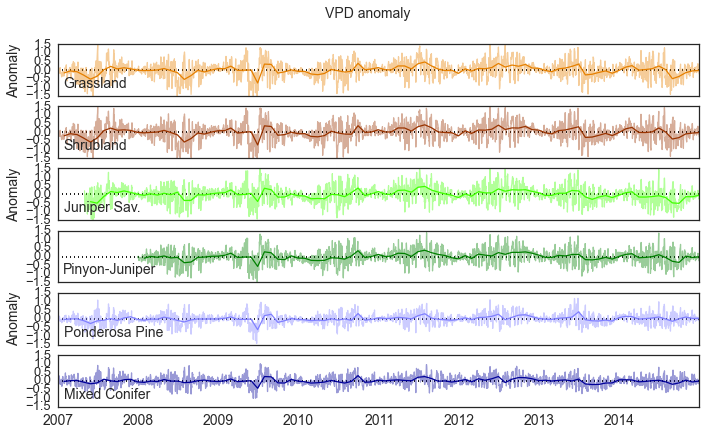

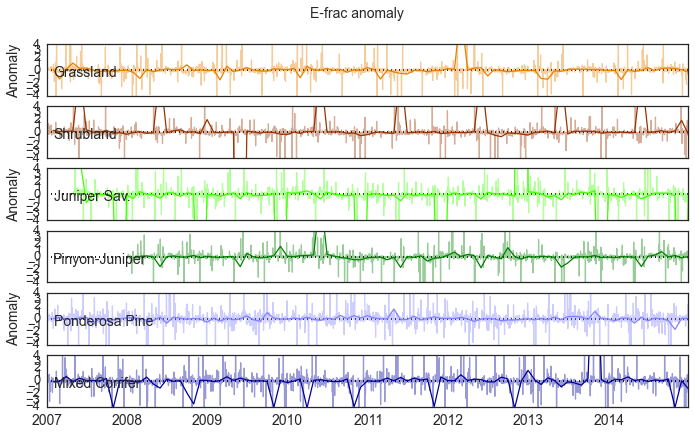

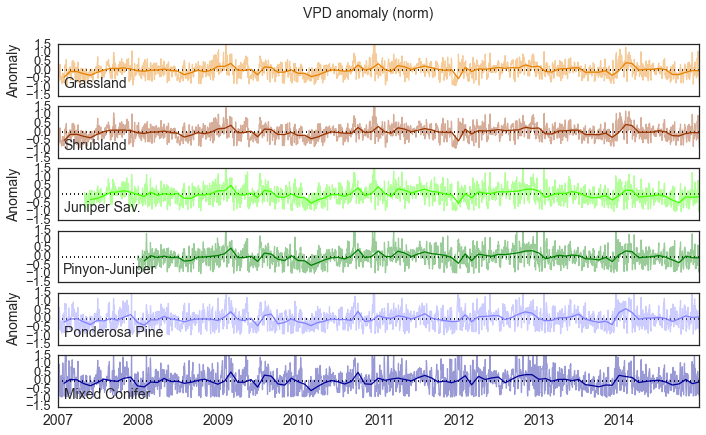

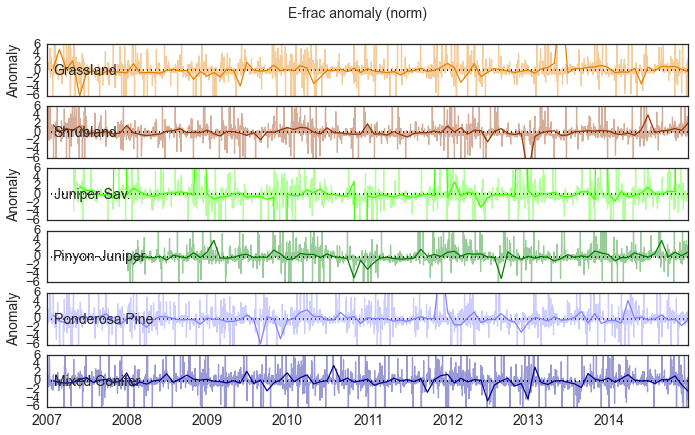

In [44]:
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )]

varlist = ['VPD_F','evap_frac', 'VPD_F','evap_frac']
ylabs = ['VPD anomaly', 'E-frac anomaly', 'VPD anomaly (norm)', 'E-frac anomaly (norm)']
ylims = [[-1.5, 1.5],[-4, 4],[-1.5, 1.5],[-6, 6]]

for i, anom in enumerate([vpd_anom, ef_anom, vpd_anom_n, ef_anom_n]):
    # Resample anomaly to monthly mean
    anom_m = { i : anom[i].resample('1M', how='mean') for i in anom.keys() }
    fig = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
    plot_tseries( anom, anom_m, varlist[i], varlist[i], -1,fig, 'Anomaly', ylims=ylims[i])
    plt.suptitle(ylabs[i], size=14)